## read in data

In [1]:
import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

prop = 'soc'
tgt = 'soc_log1p'
version = 'v20250301'

covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/data_train_{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any')
test = pd.read_parquet(f'./material/data_test_{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any')

# train = train.loc[train['soc']<50]
# test = test.loc[test['soc']<50]

## train the model

In [2]:
# train the model
from trees_rf import cast_tree_rf
ttprint(f'start training')
model.fit(train[covs], train[tgt])
ttprint(f'finish training')
model = cast_tree_rf(model)


[15:11:35] start training
[15:11:40] finish training


## generate prediction

In [3]:
# tree predictions
tree_predictions = model.predict(test[covs])

# get point prediction
y_pred = np.mean(tree_predictions, axis=0)
y_pred = np.expm1(y_pred)
test['pred'] = y_pred

# uncertainty in std
tree_predictions = np.expm1(tree_predictions)
test['pred_std'] = np.std(tree_predictions, axis=0)


In [4]:
test.loc[test['lc_survey']=='bare land & lichens/moss','lc_survey'] = 'bareland'
test.loc[test['lc_survey']=='water areas & wetland','lc_survey'] = 'wetland'

## organize soc pairs

In [5]:
name_map = {'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'ndvi_p50',
            'ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218':'ndwi_p50',
            'ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218':'ndvi_slope',
            'ndwi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218':'ndwi_slope'}

test = test.rename(columns = name_map)
            
for col in ['ndvi_p50','ndwi_p50']:
    test[col] = (test[col]-125)/125

In [6]:
tcol = ['lat', 'lon', 'time', 'soc', 'pred', 'pred_std', 'lc_survey','ndvi_p50','ndwi_p50'] # time series cols
scol = ['id', 'ref', 'nuts0', 'hzn_dep']

data_list = []
ttprint('start organizing')
for iid in test['id'].unique():
    temp = test.loc[test['id'] == iid].sort_values(by=['time'])  

    static_vals = temp.iloc[0][scol].tolist()  # Extract static values once

    if len(temp) == 2:
        ts_vals = [temp[itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

    elif len(temp) > 2:
        # Case with 3 points: form 3 pairs
        ts_vals = [temp.iloc[[0, 1]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

        ts_vals = [temp.iloc[[1, 2]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

        ts_vals = [temp.iloc[[0, 2]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

pair = pd.DataFrame(data_list, columns=scol + [i + '_pair' for i in tcol])
ttprint('finish organizing')

# organize features
pair['year_change'] = pair['time_pair'].str[1] - pair['time_pair'].str[0]
pair['soc_change'] = pair['soc_pair'].str[1] - pair['soc_pair'].str[0]
pair['pred_change'] = pair['pred_pair'].str[1] - pair['pred_pair'].str[0]
pair['noise'] = np.sqrt(pair['pred_std_pair'].str[1]**2 + pair['pred_std_pair'].str[0]**2)
pair['snr'] = pair['soc_change'].abs()/pair['noise']
pair['soc_mean'] = (pair['soc_pair'].str[1] + pair['soc_pair'].str[0])/2
pair['ndvi_mean'] = (pair['ndvi_p50_pair'].str[1] + pair['ndvi_p50_pair'].str[0])/2
pair['ndwi_mean'] = (pair['ndwi_p50_pair'].str[1] + pair['ndwi_p50_pair'].str[0])/2

[15:11:50] start organizing
[15:11:55] finish organizing


In [7]:
pair.to_parquet(f'./metric/pair_predicted_{version}.pq')

## evaluate prediction accuracy for SOC change

/tmp/ipykernel_83191/1272420806.py:70: RuntimeWarning: invalid value encountered in log1p
  ax2.plot(np.log1p(show_range), np.log1p(show_range), "-k", alpha=0.5)


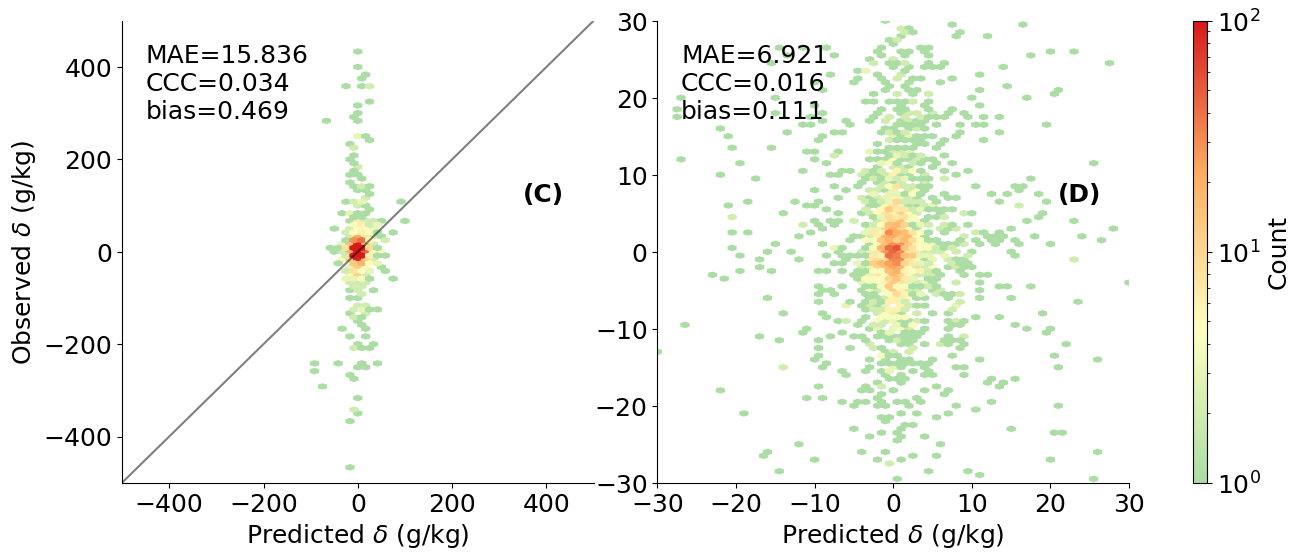

In [10]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from model_fit import calc_metrics
import math
import matplotlib.pyplot as plt

pair = pd.read_parquet(f'./metric/pair_predicted_{version}.pq')

cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

vmax = 100
titles = ['Full range', 'Without outliers']

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.03], wspace=0.2)

# Subplot 1
show_range = [-500, 500]
ax1 = fig.add_subplot(gs[0])
y_t = pair['soc_change']
y_p = pair['pred_change']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
hb1 = ax1.hexbin(y_p, y_t, gridsize=(60, 60), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=1, vmax=vmax, bins='log')
ax1.set_xlabel('Predicted $\delta$ (g/kg)')
ax1.set_ylabel('Observed $\delta$ (g/kg)')
ax1.text(0.05, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18)
ax1.text(0.85, 0.65, 
         f'(C)', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax1.plot(show_range, show_range, "-k", alpha=0.5)
ax1.set_xlim(show_range)
ax1.set_ylim(show_range)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Subplot 2
show_range = [-30, 30]
ax2 = fig.add_subplot(gs[1])
y_t = pair.loc[pair['soc_change'].abs() < 30, 'soc_change']
y_p = pair.loc[pair['soc_change'].abs() < 30, 'pred_change']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
hb2 = ax2.hexbin(y_p, y_t, gridsize=(60, 60), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=1, vmax=vmax, bins='log')
ax2.set_xlabel('Predicted $\delta$ (g/kg)')
ax2.set_ylabel(' ')
ax2.text(0.05, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18)
ax2.text(0.85, 0.65, 
         f'(D)', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax2.plot(np.log1p(show_range), np.log1p(show_range), "-k", alpha=0.5)
ax2.set_xlim(show_range)
ax2.set_ylim(show_range)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Colorbar
cbar_ax = fig.add_subplot(gs[2])
cb = fig.colorbar(hb2, cax=cbar_ax)
cb.set_label('Count')

plt.savefig(f'./figure/plot_mdl.pnt_evaluation.change_pred.svg', bbox_inches='tight')
plt.show()


## change direction estimation

In [22]:
pair['direction_pred'] = ''
pair.loc[pair['pred_change']>=0, 'direction_pred'] = 'increase'
pair.loc[pair['pred_change']<0, 'direction_pred'] = 'decrease'

pair['direction_obsv'] = ''
pair.loc[pair['soc_change']>=0, 'direction_obsv'] = 'increase'
pair.loc[pair['soc_change']<0, 'direction_obsv'] = 'decrease'

In [23]:
from sklearn.metrics import f1_score, accuracy_score

y_true = pair['direction_obsv']
y_pred = pair['direction_pred']

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, pos_label='increase')
print(f'accuracy: {accuracy}; f1: {f1}')

accuracy: 0.526; f1: 0.5698729582577132


### This is only a bit better than random guess

## SNR of paired changes

In [24]:
pair['lc_str'] = pair['lc_survey_pair'].str[0] + '-' + pair['lc_survey_pair'].str[1]


In [25]:
l1 = pair['lc_str'].unique().tolist()
l2 = [ii.replace('land','') for ii in l1]
map_l = dict(zip(l1,l2))

pair['lc_str'] = pair['lc_str'].map(map_l)


In [26]:
vc = pair['lc_survey_pair'].value_counts()
lcl = vc.index.tolist()

stable_lc = []
change_lc = []
for ii in lcl:
    if len(list(set(ii)))==1:
        stable_lc.append(ii)
    else:
        change_lc.append(ii)
        
pair['lc_change'] = ''
pair.loc[pair['lc_survey_pair'].isin(stable_lc),'lc_change'] = 0
pair.loc[pair['lc_survey_pair'].isin(change_lc),'lc_change'] = 1

pair['signal'] = pair['soc_change'].abs()

In [27]:
pair.groupby(['year_change'])['snr'].describe()

,count,mean,std,min,25%,50%,75%,max
year_change,,,,,,,,
3,1007.0,0.273692,0.381551,0.0,0.053962,0.141175,0.319778,3.879973
6,1000.0,0.308135,0.378191,0.0,0.071372,0.170575,0.386745,2.536892
9,993.0,0.290478,0.379416,0.0,0.057034,0.165997,0.374496,4.094993


In [28]:
pair.groupby(['lc_change'])['snr'].describe()

,count,mean,std,min,25%,50%,75%,max
lc_change,,,,,,,,
0,2536.0,0.295281,0.389360,0.0,0.060939,0.154910,0.361449,4.094993
1,464.0,0.265853,0.322287,0.0,0.060591,0.167241,0.323553,2.298474


In [29]:
vc = pair['lc_str'].value_counts()

lc_long = vc[vc>20].index.tolist()
pair.loc[pair['lc_str'].isin(lc_long)].groupby(['lc_str'])['snr'].describe()

,count,mean,std,min,25%,50%,75%,max
lc_str,,,,,,,,
bare-crop,38.0,0.197613,0.230953,0.005371,0.026710,0.093453,0.282347,0.778352
crop-bare,61.0,0.274499,0.332687,0.000000,0.075719,0.191071,0.310114,1.907843
crop-crop,1165.0,0.287909,0.375131,0.000000,0.066972,0.162914,0.355829,4.094993
crop-grass,107.0,0.267067,0.314132,0.005232,0.075197,0.175314,0.353268,2.298474
grass-crop,101.0,0.240967,0.281946,0.003573,0.060176,0.167193,0.293695,1.798072
grass-grass,509.0,0.297779,0.407852,0.000000,0.056675,0.155655,0.343576,2.835418
grass-wood,27.0,0.357334,0.542547,0.004556,0.050451,0.146539,0.351448,1.915402
shrub-shrub,37.0,0.369461,0.436630,0.007676,0.102578,0.207083,0.566953,2.037476
shrub-wood,21.0,0.307615,0.270488,0.000000,0.140430,0.252544,0.427644,0.986779


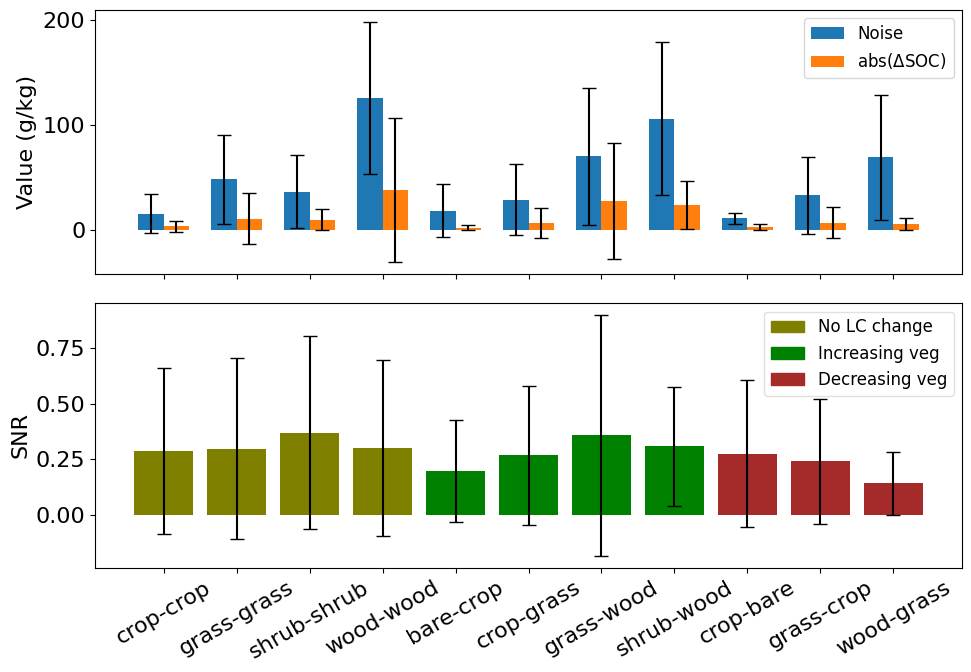

In [30]:
import matplotlib.patches as mpatches
lc_order = [
    'crop-crop', 'grass-grass', 'shrub-shrub', 'wood-wood',
    'bare-crop', 'crop-grass', 'grass-wood', 'shrub-wood', 
    'crop-bare', 'grass-crop', 'wood-grass'
]

lc_long = lc_order  
grouped_stats = pair.loc[pair['lc_str'].isin(lc_long)].groupby('lc_str')[['snr', 'noise', 'signal']].agg(['mean', 'std'])
grouped_stats.columns = ['_'.join(col) for col in grouped_stats.columns]
grouped_stats = grouped_stats.reset_index()

grouped_stats['lc_str'] = pd.Categorical(grouped_stats['lc_str'], categories=lc_order, ordered=True)
grouped_stats = grouped_stats.sort_values('lc_str')

x = np.arange(len(grouped_stats['lc_str']))
width = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

bar1 = ax1.bar(x - width/2, grouped_stats['noise_mean'], width, yerr=grouped_stats['noise_std'], capsize=5, label='Noise')
bar2 = ax1.bar(x + width/2, grouped_stats['signal_mean'], width, yerr=grouped_stats['signal_std'], capsize=5, label='Signal')

ax1.set_ylabel('Value (g/kg)')
ax1.legend(fontsize=12)

colors = ['olive','olive','olive','olive','green','green','green','green','brown','brown','brown']
ax2.bar(x, grouped_stats['snr_mean'], yerr=grouped_stats['snr_std'], capsize=5, color=colors)
ax2.set_ylabel('SNR')

# Shared X-axis labels
ax2.set_xticks(x)
ax2.set_xticklabels(grouped_stats['lc_str'], rotation=30)

olive_patch = mpatches.Patch(color='olive', label='No LC change')
green_patch = mpatches.Patch(color='green', label='Increasing veg')
brown_patch = mpatches.Patch(color='brown', label='Decreasing veg')
ax2.legend(handles=[olive_patch, green_patch, brown_patch],fontsize=12,framealpha=0.6)

plt.tight_layout()
plt.savefig('./figure/plot_pair_analysis.pdf', bbox_inches='tight')
plt.show()

In [31]:
coe = pair[['soc_mean','ndvi_mean','ndwi_mean','signal','noise','snr']].corr()

In [32]:
coe

,soc_mean,ndvi_mean,ndwi_mean,signal,noise,snr
soc_mean,1.000000,0.371747,0.343303,0.599567,0.587447,0.225444
ndvi_mean,0.371747,1.000000,0.913193,0.282375,0.635881,-0.048126
ndwi_mean,0.343303,0.913193,1.000000,0.260295,0.605829,-0.052871
signal,0.599567,0.282375,0.260295,1.000000,0.473851,0.542614
noise,0.587447,0.635881,0.605829,0.473851,1.000000,-0.038648
snr,0.225444,-0.048126,-0.052871,0.542614,-0.038648,1.000000


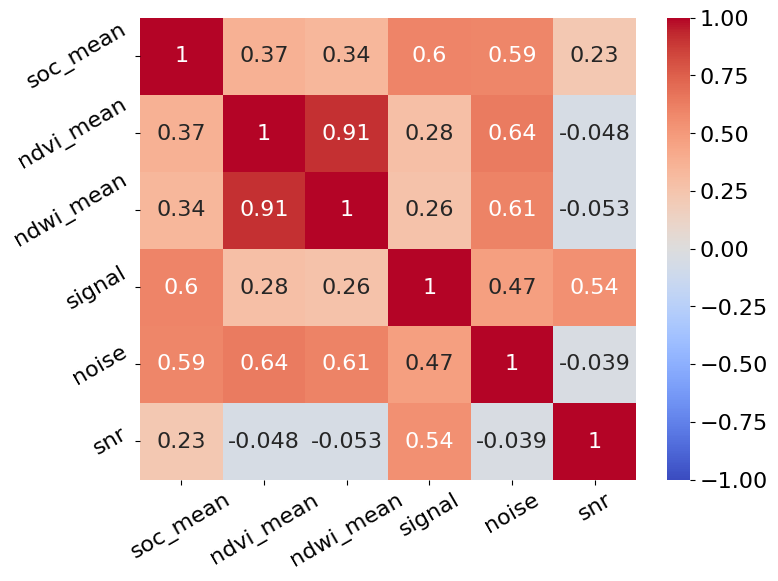

In [34]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.heatmap(coe, cmap="coolwarm", annot=True, vmin=-1, vmax=1, center=0)
ax.tick_params(axis='both', rotation=30)
plt.savefig(f'./figure/plot_corr_pair.metrics.pdf', bbox_inches='tight')
plt.show()